In [14]:
############ Packages ############

# Write in the terminal
#!pip install spacy pandas nltk unidecode
#!python -m spacy download fr_core_news_sm

import os
import re
import pandas as pd
import spacy
import matplotlib.pyplot as plt

## Exploration des données

In [ ]:
############ Reading the content of the first manifestos #############

path_to_files = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

# List of .txt files
txt_files = [f for f in os.listdir(path_to_files) if f.endswith(".txt")]


# Loop through the first 5 files and read content

first_five_files = txt_files[:3]

for i, filename in enumerate(first_five_files, 1):
    filepath = os.path.join(path_to_files, filename)
    
    # Open the file and read content
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    
    # Display file number, name, and first 400 characters for preview
    print(f"--- File {i}: {filename} ---")
    print(content[:400])  # show only the first 400 characters
    print("\n" + "="*50 + "\n")


--- File 1: EL137_L_1981_06_088_03_1_PF_04.txt ---
RÉPUBLIQUE FRANÇAISE
DÉPARTEMENT DES VOSGES
3e CIRCONSCRIPTION
ÉLECTIONS LÉGISLATIVES DU 14 JUIN 1981
1er TOUR DE SCRUTIN
Gérard BRAUN Député Sortant Maire de CORNIMONT
Claude LAROCHE Suppléant Médecin-Chef de la Maternité de REMIREMONT
Candidats de l'UNION POUR UNE NOUVELLE MAJORITÉ, présentés par le R.P.R., soutenus par l'U.D.F. et le C.N.I.P.
Le 10 Mai, les Français ont élu le socialiste Franço


--- File 2: EL136_L_1981_06_074_03_1_PF_01.txt ---
Sciences Po / fonds CEVIPOF
DEPARTEMENT DE LA HAUTE-SAVOIE ELECTIONS LEGISLATIVES DU 14 JUIN 1981 3e circonscription
Claude BIRRAUX
né le 19 janvier 1946 marié, 1 enfant Docteur ès-Sciences Conseiller Municipal d'Annemasse Elu Député en 1978 Vice-Président de la Commission de la Production et des Echanges de l'A.N. Conseiller Régional.
Pour que la France
reste la France TOUS UNIS pour la Victoire.


--- File 3: EL137_L_1981_06_092_08_1_PF_04.txt ---
Sciences Po / fonds CEVIPOF
Gérard Tolla 

In [16]:
## Exploring the CSV content

df = pd.read_csv("/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv", encoding="utf-8")

# Display the column names 
print("--------------- Column names / Attributes --------------")
print(df.columns)



--------------- Column names / Attributes --------------
Index(['id', 'date', 'subject', 'title', 'contexte-election', 'contexte-tour',
       'cote', 'departement', 'departement-nom', 'departement-insee',
       'identifiant de circonscription', 'images', 'pdf', 'ocr_url',
       'titulaire-nom', 'titulaire-prenom', 'titulaire-sexe', 'titulaire-age',
       'titulaire-age-calcule', 'titulaire-age-tranche',
       'titulaire-profession', 'titulaire-mandat-en-cours',
       'titulaire-mandat-passe', 'titulaire-associations',
       'titulaire-autres-statuts', 'titulaire-soutien', 'titulaire-liste',
       'titulaire-decorations', 'suppleant-nom', 'suppleant-prenom',
       'suppleant-sexe', 'suppleant-age', 'suppleant-age-calcule',
       'suppleant-age-tranche', 'suppleant-profession',
       'suppleant-mandat-en-cours', 'suppleant-mandat-passe',
       'suppleant-associations', 'suppleant-autres-statuts',
       'suppleant-soutien', 'suppleant-liste', 'suppleant-decorations'],
      d

In [17]:
############ Display the first 5 rows of the csv for columns of interest ################

print("\n--------------- First 5 rows of the DataFrame ---------------")

# List of columns to display
columns_to_show = ['id', 'contexte-election', 'contexte-tour', 'titulaire-soutien', 'titulaire-liste']

# Display only these columns
print(df[columns_to_show].head())  # first 5 rows



--------------- First 5 rows of the DataFrame ---------------
                               id contexte-election  contexte-tour  \
0  EL134_L_1981_06_001_01_1_PF_01      législatives              1   
1  EL134_L_1981_06_001_01_1_PF_02      législatives              1   
2  EL134_L_1981_06_001_01_1_PF_03      législatives              1   
3  EL134_L_1981_06_001_01_1_PF_04      législatives              1   
4  EL134_L_1981_06_001_01_1_PF_05      législatives              1   

                                   titulaire-soutien  \
0                            Parti socialiste unifié   
1                          Parti communiste français   
2  Parti socialiste;Mouvement des radicaux de gauche   
3              Fédération des socialistes démocrates   
4  Rassemblement pour la République;Union pour la...   

                   titulaire-liste  
0                    non mentionné  
1               Union de la gauche  
2                    non mentionné  
3                    non mentio

In [18]:
# Columns to check
cols = ['titulaire-soutien', 'titulaire-liste']

for col in cols:
    # Count NaN (missing values)
    num_missing = df[col].isna().sum()
    
    # Count empty strings
    num_empty = (df[col] == '').sum()
    
    # Count cells with 'Non mentionné'
    num_non_mentionne = (df[col] == 'non mentionné').sum()
    
    # Total not mentioned
    total_not_mentioned = num_missing + num_empty + num_non_mentionne
    
    print(f"-- Column '{col}' --")
    print(f"Number of modalities 'non mentionné' (NaN, empty, 'non mentionné'): {total_not_mentioned}\n")

print("-- Total number of modalities --")
print(f"Total number of rows: {len(df)}\n")



-- Column 'titulaire-soutien' --
Number of modalities 'non mentionné' (NaN, empty, 'non mentionné'): 676

-- Column 'titulaire-liste' --
Number of modalities 'non mentionné' (NaN, empty, 'non mentionné'): 1184

-- Total number of modalities --
Total number of rows: 3121



## Treatment of "Non mentionné" and Analysis of Modalities

To choose beetween the modalities `titulaire-soutien` and `titulaire-liste` in our prediction, we will:

1. **Filter out rows** that are either `NaN`, empty (`""`), or `"Non mentionné"` to create a cleaned dataset.

2. **Count occurrences** of each valid modality and classify them into intervals (bins) according to the number of manifestos:  
   - 0–10, 10–20, 20–30, 30–40, 40–50, 50+

3. **Compute summary tables**


In [19]:
# Dictionnaire pour conserver le nombre de catégories >= 30 par colonne
categories_30_plus_dict = {}

# Defining the bins (intervals)
bins = [0,10,20,30,40,50,float('inf')]  
labels = ['0-10','10-20','20-30','30-40','40-50','50+']

# Columns to analyze
cols = ['titulaire-soutien', 'titulaire-liste']

for col in cols:
    # Separate rows with 'Non mentionné'
    non_mentionne_mask = df[col] == 'non mentionné'
    num_non_mentionne = non_mentionne_mask.sum()
    
    print(f"\n--- Column '{col}' ---")
    print(f"Number of rows with 'non mentionné': {num_non_mentionne}")
    
    # Work only on valid modalities (exclude NaN, empty, 'non mentionné')
    df_valid = df[~(df[col].isna() | (df[col] == '') | non_mentionne_mask)]
    
    # Count the occurrences of each valid modality
    counts = df_valid[col].value_counts()

     # Nombre de catégories avec au moins 30 manifestes
    num_categories_30_plus = (counts >= 30).sum()
    categories_30_plus_dict[col] = num_categories_30_plus  
    
    print(f"Number of categories with at least 30 manifestos: {num_categories_30_plus}")
    
    
    # Bin the counts into the defined intervals
    binned = pd.cut(counts, bins=bins, labels=labels, right=False)
    
    # Count how many modalities fall into each bin
    summary_modalities = binned.value_counts().sort_index()
    
    # Compute total number of manifestos in each bin
    summary_manifestos = binned.groupby(binned).apply(lambda x: counts[x.index].sum()).reindex(labels)
    
    # Combine into a DataFrame
    summary_df = pd.DataFrame({
        'Number of modalities': summary_modalities,
        'Number of manifestos': summary_manifestos
    })
    
    # Add Total row
    total_row = pd.DataFrame({
        'Number of modalities': [summary_df['Number of modalities'].sum()],
        'Number of manifestos': [summary_df['Number of manifestos'].sum()]
    }, index=['Total'])
    
    summary_df = pd.concat([summary_df, total_row])
    
    # Display the result
    print(summary_df)



--- Column 'titulaire-soutien' ---
Number of rows with 'non mentionné': 676
Number of categories with at least 30 manifestos: 13
       Number of modalities  Number of manifestos
0-10                    252                   468
10-20                     3                    35
20-30                     1                    22
30-40                     3                   103
40-50                     1                    44
50+                       9                  1773
Total                   269                  2445

--- Column 'titulaire-liste' ---
Number of rows with 'non mentionné': 1184
Number of categories with at least 30 manifestos: 10
       Number of modalities  Number of manifestos
0-10                    116                   196
10-20                     4                    51
20-30                     2                    46
30-40                     2                    70
40-50                     3                   130
50+                       5              

/tmp/ipykernel_48368/374401449.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_manifestos = binned.groupby(binned).apply(lambda x: counts[x.index].sum()).reindex(labels)
/tmp/ipykernel_48368/374401449.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_manifestos = binned.groupby(binned).apply(lambda x: counts[x.index].sum()).reindex(labels)


It appears that 53% of the manifestos have an identified listed candidate associated with a municipality appearing in at least 30 manifestos, whereas 62% of the manifestos have an identified supporter associated with a municipality appearing in at least 30 manifestos.
Therefore, we choose to work with the 'titulaire-soutien' as variable to implement our classifier model. So we have a total of **1,920 usable manifestos** for NLP algorithms, noting that we consider we need at least 30 manifestos per category to make reliable predictions.

Indeed, the graph below shows that, for the variable titulaire-liste, most modalities that occur in strictly fewer than 30 manifestos appear in less than five manifestos. This makes predicting the list practically infeasible.

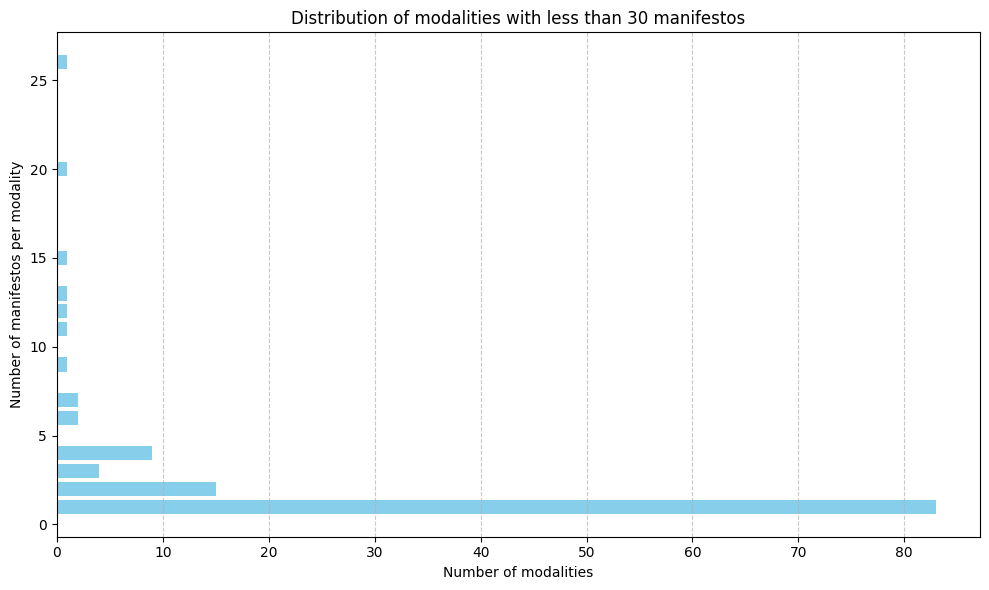

In [8]:
# Count the number of manifestos per modality
counts = df['titulaire-liste'].value_counts()

# Keep only modalities with strictly less than 30 manifestos
counts_under_30 = counts[counts < 30]

# Count how many modalities have each number of manifestos
freq_of_counts = counts_under_30.value_counts().sort_index()

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(freq_of_counts.index, freq_of_counts.values, color='skyblue')
plt.xlabel("Number of modalities")
plt.ylabel("Number of manifestos per modality")
plt.title("Distribution of modalities with less than 30 manifestos")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


On ne conserve que les manifestes exploitables (dont le support est clairement ientifié).

In [25]:
# Remove unusable manifestos
df_valid = df[~(df['titulaire-soutien'].isna() | 
                (df['titulaire-soutien'] == '') | 
                (df['titulaire-soutien'] == 'non mentionné'))]

## Statistiques descriptives

#### Number of exploitable manifestos and number of categories

As seen before, we have a total of **1,920 usable manifestos** for NLP algorithms and **13 modalities** associated to this manifestos.

Number of categories with more than 30 manifestos: 13

--- Summary Table (categories > 30 manifestos) ---
                                             Category  Number of manifestos
0                                    Parti socialiste                   572
1                           Parti communiste français                   465
2                                      Lutte ouvrière                   159
3                             Parti socialiste unifié                   148
4                    Rassemblement pour la République                   127
5   Rassemblement pour la République;Union pour la...                   103
6                  Union pour la démocratie française                    83
7   Union pour la démocratie française;Rassembleme...                    65
8                    Mouvement des radicaux de gauche                    51
9                                      Front national                    44
10  Parti socialiste;Mouvement des radicaux de gauche     

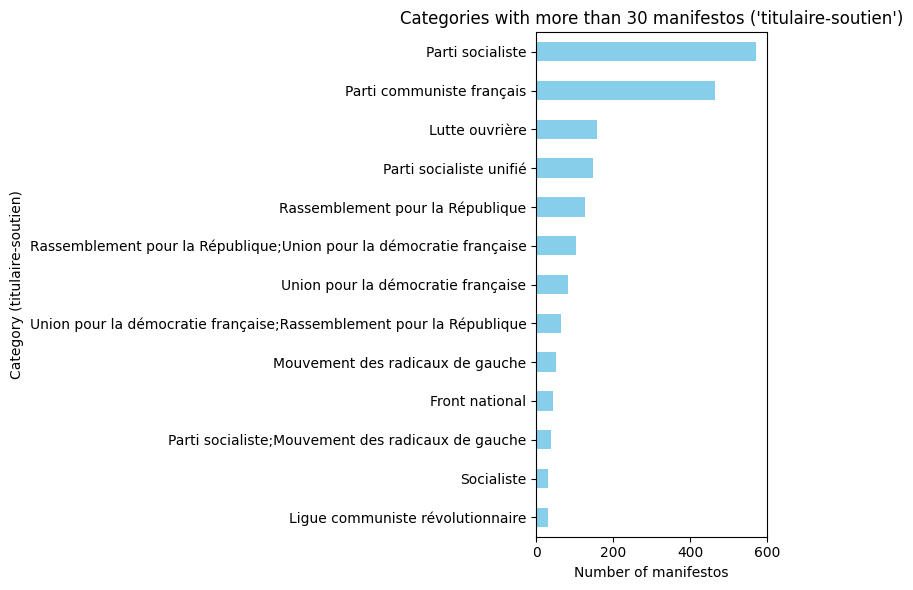

In [26]:


# Counts and visualizes political manifestos for 'titulaire-soutien'
# Only categories with more than 30 manifestos


# Count manifestos per category
counts = df_valid['titulaire-soutien'].value_counts()

# Keep only categories with more than 30 manifestos
counts_filtered = counts[counts > 30]

# Number of categories with more than 30 manifestos
num_categories_30_plus = counts_filtered.shape[0]
print(f"Number of categories with more than 30 manifestos: {num_categories_30_plus}\n")

# Create summary table
summary_df = pd.DataFrame({
    'Category': counts_filtered.index,
    'Number of manifestos': counts_filtered.values
})
print("--- Summary Table (categories > 30 manifestos) ---")
print(summary_df)

# Plot horizontal bar chart
plt.figure(figsize=(8,6))
counts_filtered.plot(kind='barh', color='skyblue')
plt.xlabel("Number of manifestos")
plt.ylabel("Category (titulaire-soutien)")
plt.title("Categories with more than 30 manifestos ('titulaire-soutien')")
plt.gca().invert_yaxis()  # largest values on top
plt.tight_layout()
plt.show()



# Prepartion of data for statistical analyses or advanced NLP models

**Role of this file:**
1. **OCR artifact cleaning:** remove line breaks, special characters, and isolated small numbers.
2. **Text normalization:** convert text to lowercase, remove unnecessary punctuation.
3. **Tokenization and filtering:** remove stopwords, punctuation, and whitespace tokens.
4. **Lemmatization:** reduce words to their base form.
5. **Metadata extraction:** extract document ID, candidate, party, support, and year from filenames.
6. **DataFrame creation:** each row corresponds to a document (a candidat) with preprocessed text and associated metadata.

In [9]:
############# Load the French language model ############

nlp = spacy.load("fr_core_news_sm")

In [10]:
############# functions to clean data ############

def clean_ocr(text):
    """Basic cleaning of OCR artifacts and noise."""
    # Remove unnecessary line breaks and unusual special characters
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\w\s\.,;!?]', '', text) 
    # Remove isolated small digit sequences (often page numbers or scan errors)
    text = re.sub(r'\b\d{1,2}\b', '', text)
    return text.strip()

def preprocess_text(text, use_lemma=True):
    """Normalization: Lowercasing, OCR cleaning, Tokenization, Stopwords removal, and Lemmatization."""
    # Convert to lowercase and apply OCR cleaning
    text = clean_ocr(text.lower())
    
    # Process text with spaCy pipeline
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        # Filter out stop words, punctuation, and whitespace
        if not token.is_stop and not token.is_punct and not token.is_space:
            if use_lemma:
                tokens.append(token.lemma_)
            else:
                tokens.append(token.text)
                
    return " ".join(tokens)


In [11]:
############# Processing loop #############

# Path to source files
path_to_files = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"
data = []   

# We iterate through every file in the directory
for filename in os.listdir(path_to_files):
    if filename.endswith(".txt"):
        with open(os.path.join(path_to_files, filename), 'r', encoding='utf-8') as f:
            raw_content = f.read()
            
            # Apply NLP Preprocessing
            clean_content = preprocess_text(raw_content)
            
            # Extract metadata from filename (Assumes format: id_candidate_party.txt)
            # Adjust the split logic based on your actual naming convention
            parts = filename.replace(".txt", "").split("_")
            
            # Store everything in a list of dictionaries
            data.append({
                "doc_id": parts[0] if len(parts) > 0 else filename,
                "text": clean_content,
                "annee": 1981,
                "titulaire": parts[1] if len(parts) > 1 else "Unknown",
                "soutien": "To be completed", 
                "parti": parts[2] if len(parts) > 2 else "Unknown"
            })


In [12]:
############# DataFrame Creation #############
# This converts the list of dictionaries into a structured DataFrame
df = pd.DataFrame(data)

# Display the first few rows
print(df.head())

  doc_id                                               text  annee titulaire  \
0  EL137  république français département vosge troisièm...   1981         L   
1  EL136  science po fonds cevipof departement hautesavo...   1981         L   
2  EL137  science po fonds cevipof gérard toller raymond...   1981         L   
3  EL137  philippe bassinet candidat socialiste majorité...   1981         L   
4  EL137  candidat vallot françois ingénieur voter franç...   1981         L   

           soutien parti  
0  To be completed  1981  
1  To be completed  1981  
2  To be completed  1981  
3  To be completed  1981  
4  To be completed  1981  



1. **Separate the rows** with the value `"Non mentionné"` from the valid data.  
   - This allows us to keep track of missing or unspecified information without including it in the main analysis.